In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
def get_image_paths(root_dir):
    valid_ext = ('.jpg', '.jpeg', '.png')
    return [
        p for p in root_dir.glob('**/*')
        if p.suffix.lower() in valid_ext
    ]

# Change the paths according to your dataset location
train_dir = Path("D:/Semester 5/IMPAL/dataset/train")
train_filepaths = get_image_paths(train_dir)
val_dir = Path("D:/Semester 5/IMPAL/dataset/validation")
val_filepaths   = get_image_paths(val_dir)
test_dir = Path("D:/Semester 5/IMPAL/dataset/test")
test_filepaths = get_image_paths(test_dir)

def proc_img(filepaths):
    labels = [path.parent.name for path in filepaths]

    filepaths = pd.Series([str(path) for path in filepaths], name='Filepath')
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepaths, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)

    return df


train_df = proc_img(train_filepaths)
val_df = proc_img(val_filepaths)
test_df = proc_img(test_filepaths)


In [3]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 917

Number of different labels: 8

Labels: ['mango' 'banana' 'watermelon' 'orange' 'grapes' 'apple' 'kiwi' 'melon']


In [4]:
train_df.head()

Filepath       Label
0  D:\Semester 5\IMPAL\dataset\train\mango\Image_...       mango
1  D:\Semester 5\IMPAL\dataset\train\banana\Image...      banana
2  D:\Semester 5\IMPAL\dataset\train\watermelon\I...  watermelon
3  D:\Semester 5\IMPAL\dataset\train\orange\WIN_2...      orange
4  D:\Semester 5\IMPAL\dataset\train\mango\IMG_20...       mango

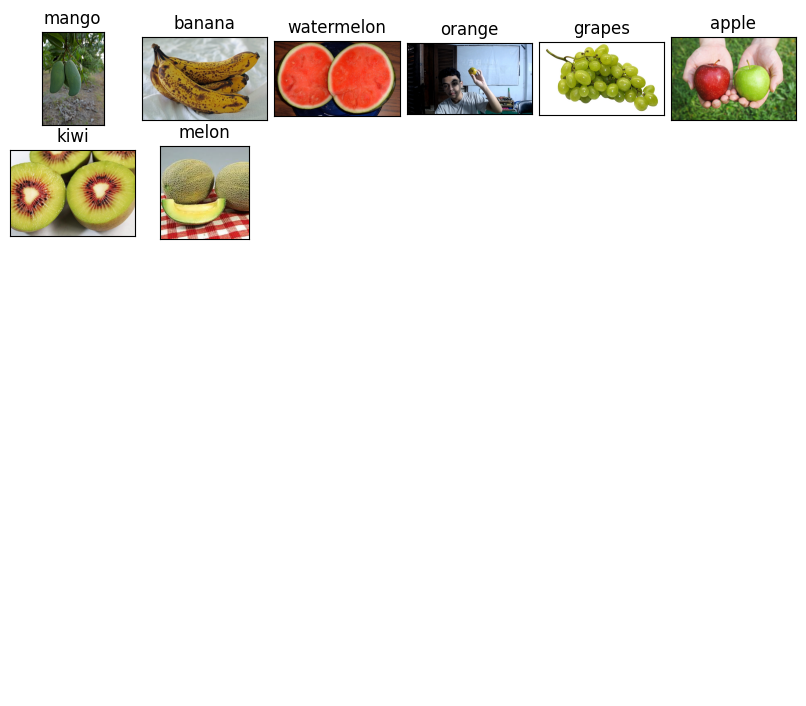

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
num_images = len(train_df.Label.unique())

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(plt.imread(df_unique.iloc[i].Filepath))
        ax.set_title(df_unique.iloc[i].Label, fontsize=12)
    else:
        ax.axis("off")

plt.tight_layout(pad=0.5)
plt.show()


In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 917 validated image filenames belonging to 8 classes.
Found 79 validated image filenames belonging to 8 classes.
Found 79 validated image filenames belonging to 8 classes.


In [ ]:

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [8]:
num_classes = len(train_images.class_indices)

pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
 2/29 ━━━━━━━━━━━━━━━━━━━━ 21s 798ms/step - accuracy: 0.1797 - loss: 2.0949

c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 731ms/step - accuracy: 0.7405 - loss: 0.8361 - val_accuracy: 0.9494 - val_loss: 0.2499
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 637ms/step - accuracy: 0.9586 - loss: 0.1349 - val_accuracy: 0.9620 - val_loss: 0.1400
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 657ms/step - accuracy: 0.9935 - loss: 0.0402 - val_accuracy: 0.9620 - val_loss: 0.1039
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 664ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 0.9873 - val_loss: 0.0673
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 676ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0343


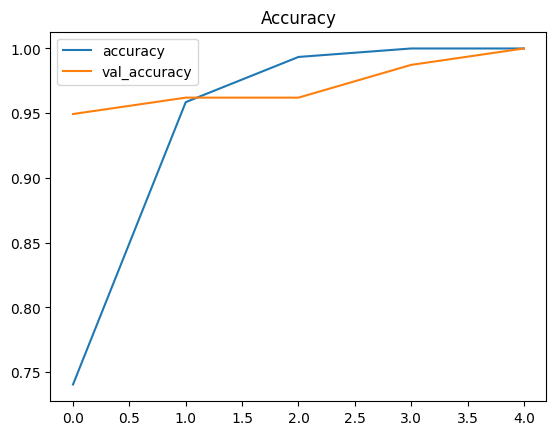

In [9]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

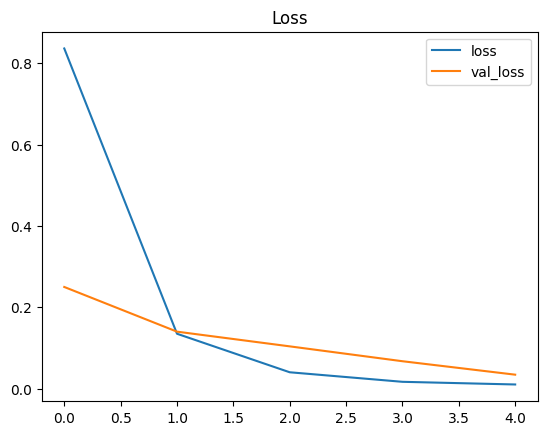

In [10]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step


In [12]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 100.00%


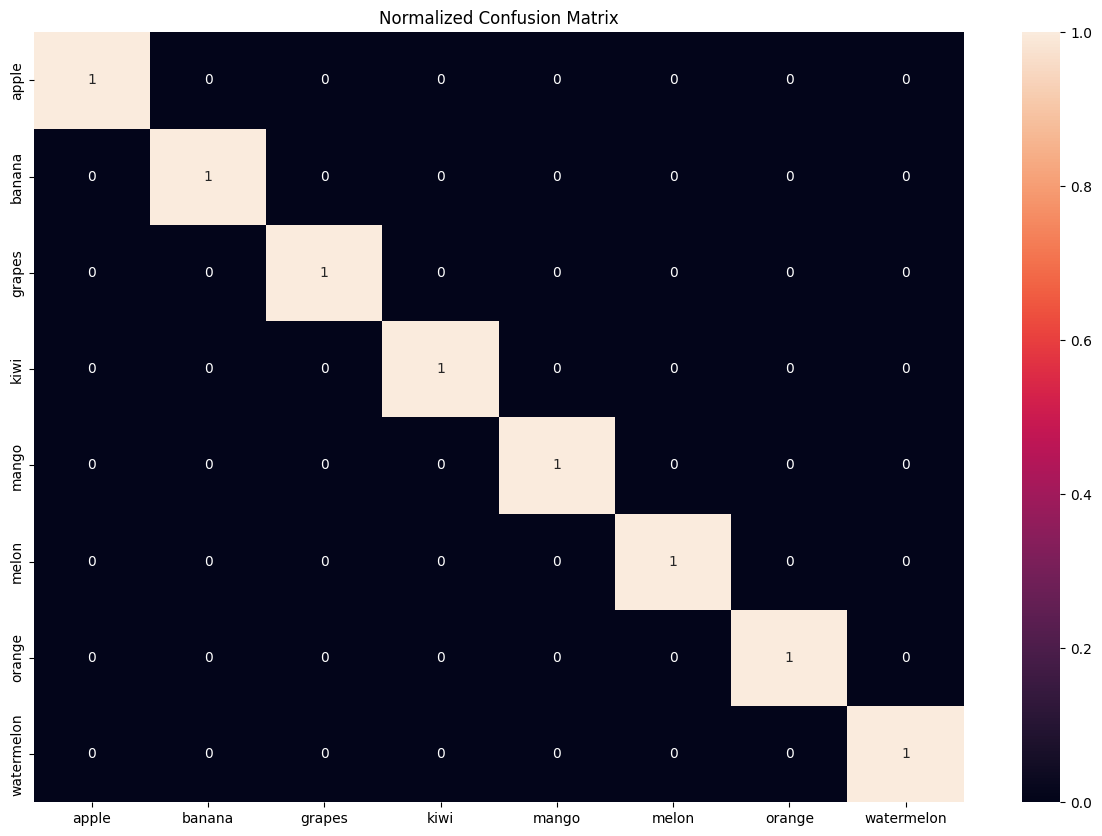

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

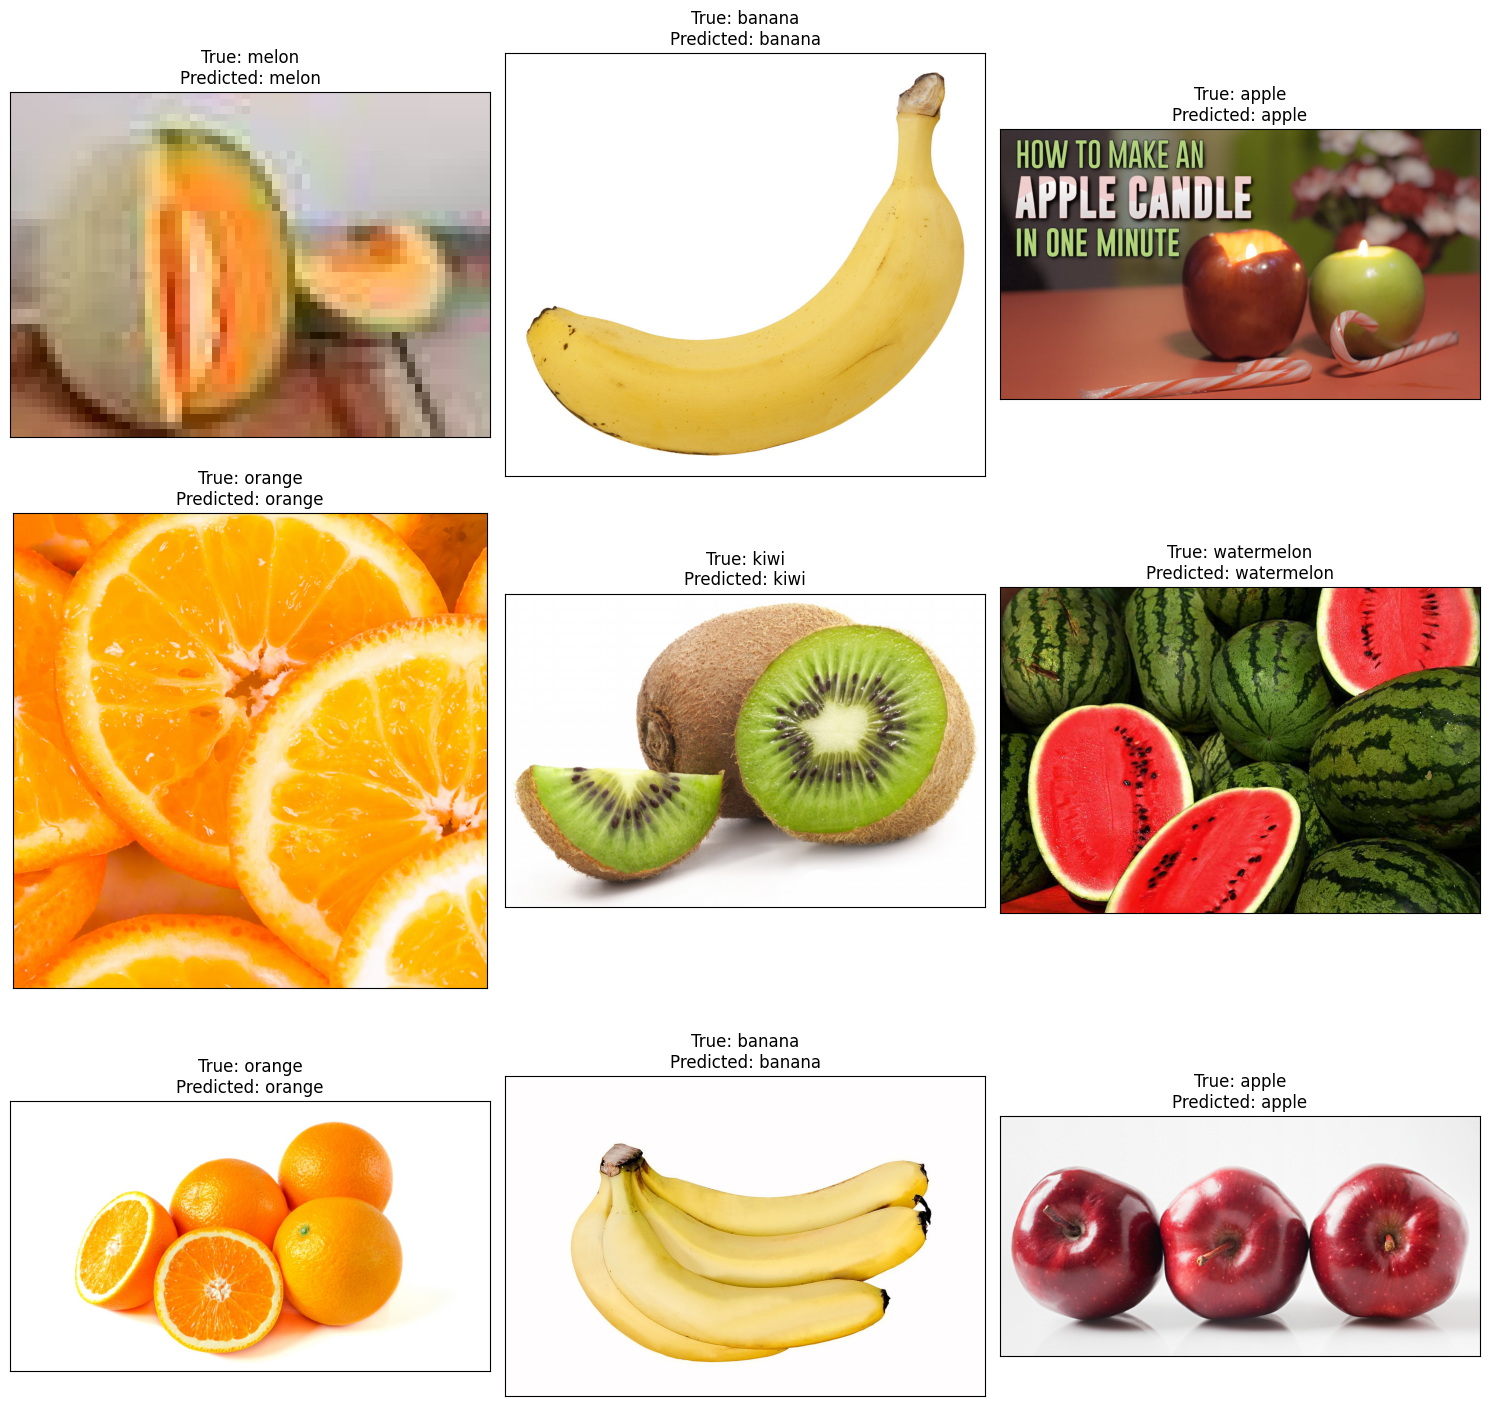

In [14]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    
    grads = tape.gradient(class_channel, last_conv_layer_output)

    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    
    heatmap = np.uint8(255 * heatmap)

    
    jet = cm.get_cmap("jet")

    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    
    superimposed_img.save(cam_path)

    
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)


model.layers[-1].ativation = None

c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\danar\AppData\Local\Temp\ipykernel_24596\2731422595.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


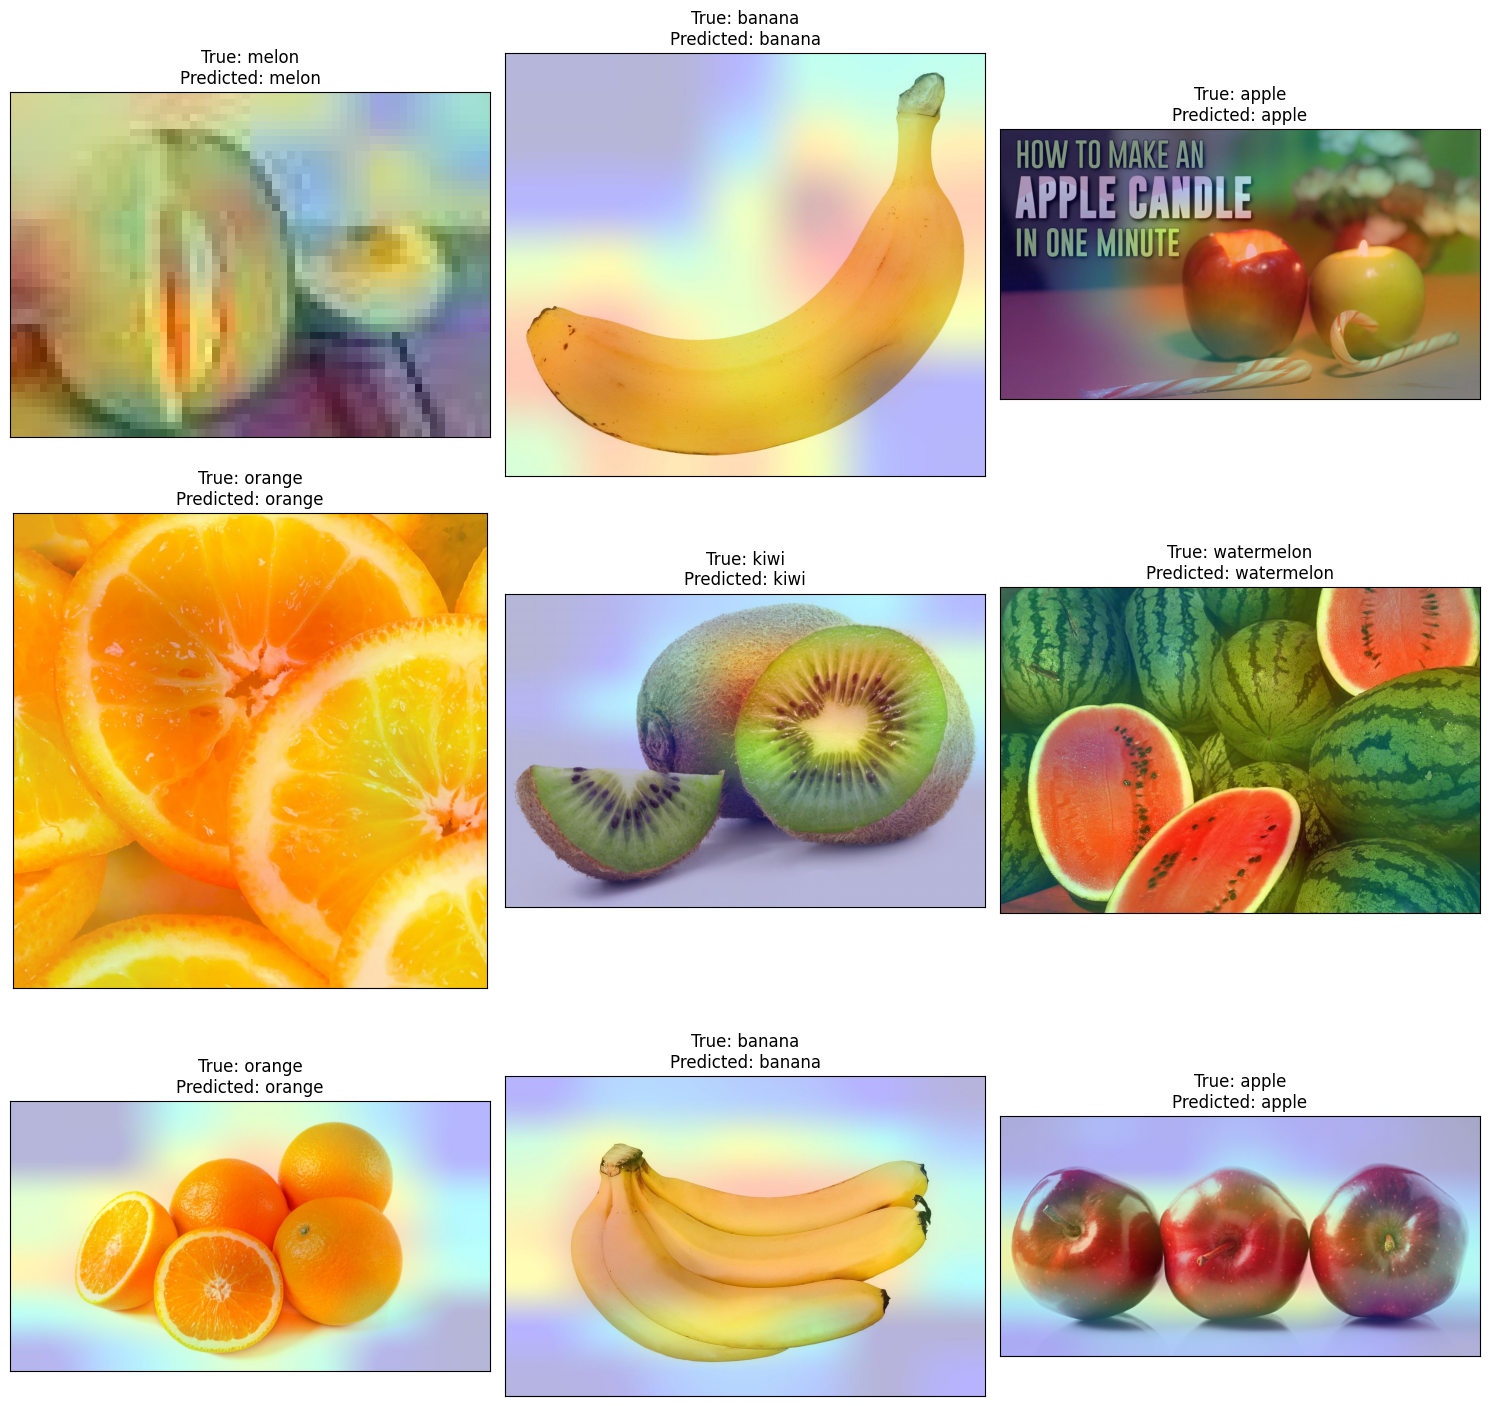

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
class_indices = train_images.class_indices

idx_to_class = {v: k for k, v in class_indices.items()}

print(idx_to_class)


{0: 'apple', 1: 'banana', 2: 'grapes', 3: 'kiwi', 4: 'mango', 5: 'melon', 6: 'orange', 7: 'watermelon'}


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(model, img_path, target_size=(224, 224)):
    # Load image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess (MobileNetV2)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    predicted_idx = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)

    predicted_label = idx_to_class[predicted_idx]

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.show()

    return predicted_label, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


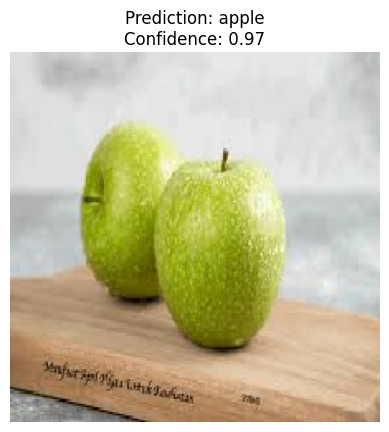

Predicted label: apple
Confidence: 0.96890634


In [ ]:
# Test the function with an image path (Change the path as needed)
img_path = "C:\\Users\\danar\\Downloads\\apelijo2.jpg"

label, conf = predict_image(model, img_path)

print("Predicted label:", label)
print("Confidence:", conf)